In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [24]:
data = pd.read_csv('Potato.csv')

In [25]:
#Drop na's.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)

,date,centre_name,commodity_name,price
0,2001-01-01,DELHI,Potato,3.0
1,2001-01-01,MUMBAI,Potato,5.5
2,2001-01-01,KOLKATA,Potato,2.5
3,2001-01-02,DELHI,Potato,7.0
4,2001-01-02,MUMBAI,Potato,10.5
...,...,...,...,...
5076,2015-12-11,MUMBAI,Potato,13.0
5077,2015-12-11,KOLKATA,Potato,6.0
5078,2015-12-14,DELHI,Potato,18.0
5079,2015-12-14,MUMBAI,Potato,31.0


In [26]:
#calculate average price for each centre for each day 
data_gp = data.sort_values('date').groupby(['centre_name', 'date'], as_index=False)
data_gp = data_gp.agg({'price':['mean']})
data_gp.columns = ['centre_name', 'date', 'price']
data_gp.head()

,centre_name,date,price
0,DELHI,2001-01-01,3.0
1,DELHI,2001-01-02,7.0
2,DELHI,2001-01-03,5.0
3,DELHI,2001-01-04,4.0
4,DELHI,2001-01-08,9.0


In [27]:
#centre_1_train_dataset
centre_1_data = data_gp.loc[(data_gp['centre_name']=="DELHI"),["price"]].values
centre_1_data = centre_1_data.astype("float32")

#centre_2_train_dataset
centre_2_data = data_gp.loc[(data_gp['centre_name']=="KOLKATA"),["price"]].values
centre_2_data = centre_2_data.astype("float32")

#centre_2_train_dataset
centre_3_data = data_gp.loc[(data_gp['centre_name']=="MUMBAI"),["price"]].values
centre_3_data = centre_3_data.astype("float32")

print(centre_1_data.size,centre_2_data.size,centre_3_data.size)

1708 1677 1696


In [28]:
#take last year as test dataset
train_centre_1 = centre_1_data[:-365]
test_centre_1 = centre_1_data[-365:]

train_centre_2 = centre_2_data[:-365]
test_centre_2 = centre_2_data[-365:]

train_centre_3 = centre_3_data[:-365]
test_centre_3 = centre_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_centre_1), len(test_centre_1)))

train size: 1343, test size: 365


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#transform the data using minmax scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_centre_1 = scaler.fit_transform(train_centre_1)
test_centre_1 = scaler.transform(test_centre_1)

train_centre_2 = scaler_2.fit_transform(train_centre_2)
test_centre_2 = scaler_2.transform(test_centre_2)

train_centre_3 = scaler_3.fit_transform(train_centre_3)
test_centre_3 = scaler_3.transform(test_centre_3)

In [30]:
#train:

time_step = 30
datax_centre_1=[]
datay_centre_1=[]

for i in range(len(train_centre_1)-time_step-1):
    datax_centre_1.append(train_centre_1[i:(i+time_step),0])
    datay_centre_1.append(train_centre_1[i+time_step,0])
trainx_centre_1=np.array(datax_centre_1)
trainy_centre_1=np.array(datay_centre_1)

datax_centre_2=[]
datay_centre_2=[]

for i in range(len(train_centre_2)-time_step-1):
    datax_centre_2.append(train_centre_2[i:(i+time_step),0])
    datay_centre_2.append(train_centre_2[i+time_step,0])
trainx_centre_2=np.array(datax_centre_2)
trainy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(train_centre_3)-time_step-1):
    datax_centre_3.append(train_centre_3[i:(i+time_step),0])
    datay_centre_3.append(train_centre_3[i+time_step,0])
trainx_centre_3=np.array(datax_centre_3)
trainy_centre_3=np.array(datay_centre_3)

In [31]:
#test:

datax_centre_1=[]
datay_centre_1=[]

for i in range(len(test_centre_1)-time_step-1):
    datax_centre_1.append(test_centre_1[i:(i+time_step),0])
    datay_centre_1.append(test_centre_1[i+time_step,0])
testx_centre_1=np.array(datax_centre_1)
testy_centre_1=np.array(datay_centre_1)


datax_centre_2=[]
datay_centre_2=[]

for i in range(len(test_centre_2)-time_step-1):
    datax_centre_2.append(test_centre_2[i:(i+time_step),0])
    datay_centre_2.append(test_centre_2[i+time_step,0])
testx_centre_2=np.array(datax_centre_2)
testy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(test_centre_3)-time_step-1):
    datax_centre_3.append(test_centre_3[i:(i+time_step),0])
    datay_centre_3.append(test_centre_3[i+time_step,0])
testx_centre_3=np.array(datax_centre_3)
testy_centre_3=np.array(datay_centre_3)

In [32]:
trainx_centre_1=np.reshape(trainx_centre_1, (trainx_centre_1.shape[0],1,trainx_centre_1.shape[1]))
testx_centre_1=np.reshape(testx_centre_1, (testx_centre_1.shape[0],1,testx_centre_1.shape[1]))

trainx_centre_2=np.reshape(trainx_centre_2, (trainx_centre_2.shape[0],1,trainx_centre_2.shape[1]))
testx_centre_2=np.reshape(testx_centre_2, (testx_centre_2.shape[0],1,testx_centre_2.shape[1]))

trainx_centre_3=np.reshape(trainx_centre_3, (trainx_centre_3.shape[0],1,trainx_centre_3.shape[1]))
testx_centre_3=np.reshape(testx_centre_3, (testx_centre_3.shape[0],1,testx_centre_3.shape[1]))


In [33]:
model =Sequential()
model.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model.fit(trainx_centre_1, trainy_centre_1, epochs=100, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/100
37/37 [==============================] - 0s 10ms/step - loss: 0.8654 - val_loss: 0.8072
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.7301 - val_loss: 0.6988
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6630 - val_loss: 0.6394
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6233 - val_loss: 0.6018
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5957 - val_loss: 0.5755
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5746 - val_loss: 0.5559
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5573 - val_loss: 0.5404
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5423 - val_loss: 0.5277
Epoch 9/100
37/37 [==============================] - 0s 3ms/step - loss: 0.5287 - val_loss: 0.5169
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5161 - val_loss: 0.5074
Epoch 11

In [34]:
model_2 =Sequential()
model_2.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
history_2 = model.fit(trainx_centre_2, trainy_centre_2, epochs=100, batch_size=32,   validation_split=0.1, shuffle=False)

Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 0.2748 - val_loss: 0.0872
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0618 - val_loss: 0.0572
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0510
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0469
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0440
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0419
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0403
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0391
Epoch 9/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0383
Epoch 10/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0317 - val_loss: 0.0376
Epoch 11/

In [35]:
model_3 =Sequential()
model_3.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_centre_3, trainy_centre_3, epochs=100, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0380 - val_loss: 0.0333
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0319
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0310
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0304
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0300
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0296
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0293
Epoch 8/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0310 - val_loss: 0.0291
Epoch 9/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0289
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0286
Epoch 11/

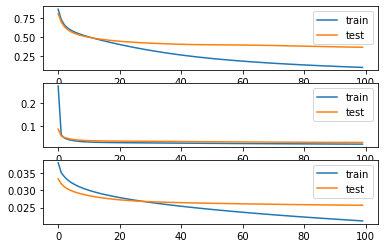

In [36]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 2)
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [37]:
trainy_centre_1 = trainy_centre_1.reshape(1,-1)
testy_centre_1 = testy_centre_1.reshape(1,-1)

trainy_centre_2 = trainy_centre_2.reshape(1,-1)
testy_centre_2 = testy_centre_2.reshape(1,-1)

trainy_centre_3 = trainy_centre_3.reshape(1,-1)
testy_centre_3 = testy_centre_3.reshape(1,-1)

In [38]:
testPredict_centre_1 = model.predict(testx_centre_1)
testPredict_centre_1 = scaler.inverse_transform(testPredict_centre_1)
testy_centre_1 = scaler.inverse_transform(testy_centre_1)
trainPredict_centre_1 = model.predict(trainx_centre_1)
trainPredict_centre_1 = scaler.inverse_transform(trainx_centre_1)
trainy_centre_1 = scaler.inverse_transform(trainy_centre_1)

testPredict_centre_2 = model.predict(testx_centre_2)
trainPredict_centre_2 = model.predict(trainx_centre_2)
trainPredict_centre_2 = scaler.inverse_transform(trainx_centre_2)
testPredict_centre_2 = scaler.inverse_transform(testPredict_centre_2)
testy_centre_2 = scaler.inverse_transform(testy_centre_2)
trainy_centre_2 = scaler.inverse_transform(trainy_centre_2)

testPredict_centre_3 = model.predict(testx_centre_3)
trainPredict_centre_3 = model.predict(trainx_centre_3)
trainPredict_centre_3 = scaler.inverse_transform(trainx_centre_3)
testPredict_centre_3 = scaler.inverse_transform(testPredict_centre_3)
testy_centre_3 = scaler.inverse_transform(testy_centre_3)
trainy_centre_3 = scaler.inverse_transform(trainy_centre_3)

<Figure size 432x288 with 0 Axes>

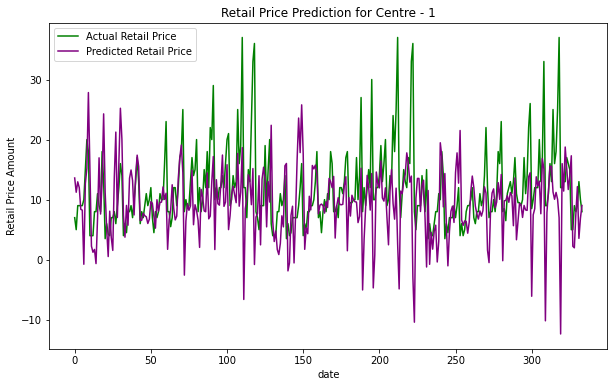

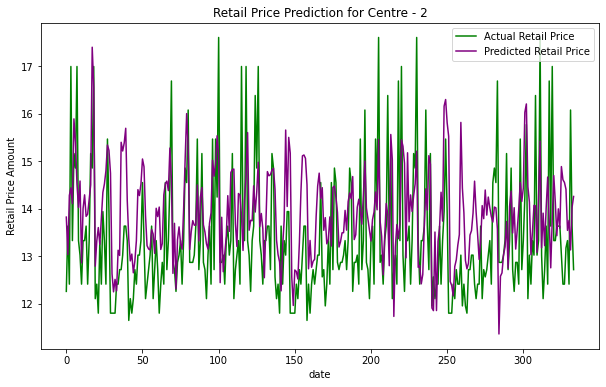

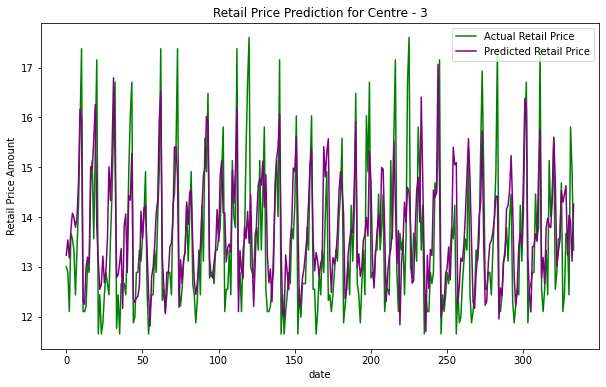

In [39]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_centre_1[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_1 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 1')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_2[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_2 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 2')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_3[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_3 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 3')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

In [40]:
# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE: {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE for centre 1 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_2[0], trainPredict_centre_2[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_2[0], testPredict_centre_2[:,0]))
# print("Train MSE for centre 2 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_3[0], trainPredict_centre_3[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_3[0], testPredict_centre_3[:,0]))
# print("Train MSE for centre 3 model : {}, Test MSE: {}".format(trainscore, testscore))

In [41]:
print(trainy_centre_2[0], trainPredict_centre_2[:,0])

[12.413201 12.413201 13.634858 ... 12.718616 13.329444 15.161931] [[11.649665 13.329444 12.413201 ... 12.413201 11.955079 12.107786]
 [13.329444 12.413201 12.260493 ... 11.955079 12.107786 12.413201]
 [12.413201 12.260493 13.634858 ... 12.107786 12.413201 12.413201]
 ...
 [12.413201 12.718616 13.02403  ... 12.871323 13.02403  13.634858]
 [12.718616 13.02403  12.107786 ... 13.02403  13.634858 12.718616]
 [13.02403  12.107786 14.856517 ... 13.634858 12.718616 13.329444]]


# Predicting 90 days of 2015

In [42]:
#use retail price of last 30 days of 2014 to predict next 90 days

#centre-1
testPredict_centre_1 = []

x_data_centre_1 = testx_centre_1[-1] #get transformed retail price values of last 30 days 
x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
yhat = model.predict(x_centre_1)
testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
x_data_centre_1 = np.append(x_data_centre_1,yhat)

for i in range (89):
        x_data_centre_1 = x_data_centre_1[1:]
        x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
        yhat = model.predict(x_centre_1)
        testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
        x_data_centre_1 = np.append(x_data_centre_1,yhat)
        
#centre-2     
testPredict_centre_2 = []

x_data_centre_2 = testx_centre_2[-1] #get transformed retail price values of last 30 days 
x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
yhat = model.predict(x_centre_2)
testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
x_data_centre_2 = np.append(x_data_centre_2,yhat)

for i in range (89):
        x_data_centre_2 = x_data_centre_2[1:]
        x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
        yhat = model.predict(x_centre_2)
        testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
        x_data_centre_2 = np.append(x_data_centre_2,yhat)
        
#centre-3
testPredict_centre_3 = []

x_data_centre_3 = testx_centre_3[-1] #get transformed retail price values of last 30 days 
x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
yhat = model.predict(x_centre_3)
testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
x_data_centre_3 = np.append(x_data_centre_3,yhat)

for i in range (89):
        x_data_centre_3 = x_data_centre_3[1:]
        x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
        yhat = model.predict(x_centre_3)
        testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
        x_data_centre_3 = np.append(x_data_centre_3,yhat)
        


In [43]:
#Create Dataframe with predicted retail prices
centre_1_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_1_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_1_test_df['centre_name'] = "DELHI"
centre_1_test_df['commodity_name'] = "Potato"
centre_1_test_df['predicted_retail_price'] = testPredict_centre_1

#Create Dataframe with predicted retail prices
centre_2_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_2_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_2_test_df['centre_name'] = "KOLKATA"
centre_2_test_df['commodity_name'] = "Potato"
centre_2_test_df['predicted_retail_price'] = testPredict_centre_2

#Create Dataframe with predicted retail prices
centre_3_test_df = pd.DataFrame(columns = ['date','centre_name','commodity_name', 'predicted_retail_price'])
centre_3_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_3_test_df['centre_name'] = "MUMBAI"
centre_3_test_df['commodity_name'] = "Potato"
centre_3_test_df['predicted_retail_price'] = testPredict_centre_3

test_df = pd.concat([centre_1_test_df , centre_2_test_df, centre_3_test_df],ignore_index=True)
test_df

,date,centre_name,commodity_name,predicted_retail_price
0,2015-01-01,DELHI,Potato,9.026934
1,2015-01-02,DELHI,Potato,6.093938
2,2015-01-03,DELHI,Potato,2.793076
3,2015-01-04,DELHI,Potato,6.338127
4,2015-01-05,DELHI,Potato,7.633702
...,...,...,...,...
265,2015-03-27,MUMBAI,Potato,16.348534
266,2015-03-28,MUMBAI,Potato,15.439583
267,2015-03-29,MUMBAI,Potato,16.309803
268,2015-03-30,MUMBAI,Potato,15.416702


In [44]:
test_df.to_csv('lstm_price_prediction_potato.csv',index=False)